# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 3784704/11490434 [========>.....................] - ETA: 0s

10420224/11490434 [==========================>...] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:41 - loss: 0.6934

  26/1875 [..............................] - ETA: 3s - loss: 0.5517   

  48/1875 [..............................] - ETA: 3s - loss: 0.4803

  73/1875 [>.............................] - ETA: 3s - loss: 0.4356

 100/1875 [>.............................] - ETA: 3s - loss: 0.4054

 127/1875 [=>............................] - ETA: 3s - loss: 0.3843

 153/1875 [=>............................] - ETA: 3s - loss: 0.3686

 177/1875 [=>............................] - ETA: 3s - loss: 0.3568

 204/1875 [==>...........................] - ETA: 3s - loss: 0.3456

 236/1875 [==>...........................] - ETA: 3s - loss: 0.3343

 264/1875 [===>..........................] - ETA: 3s - loss: 0.3258

 291/1875 [===>..........................] - ETA: 3s - loss: 0.3186

 315/1875 [====>.........................] - ETA: 3s - loss: 0.3128

 342/1875 [====>.........................] - ETA: 2s - loss: 0.3068

 362/1875 [====>.........................] - ETA: 2s - loss: 0.3027

 392/1875 [=====>........................] - ETA: 2s - loss: 0.2971

 419/1875 [=====>........................] - ETA: 2s - loss: 0.2925

 445/1875 [======>.......................] - ETA: 2s - loss: 0.2883

 474/1875 [======>.......................] - ETA: 2s - loss: 0.2840

 497/1875 [======>.......................] - ETA: 2s - loss: 0.2808

 524/1875 [=======>......................] - ETA: 2s - loss: 0.2772

 550/1875 [=======>......................] - ETA: 2s - loss: 0.2740

 577/1875 [========>.....................] - ETA: 2s - loss: 0.2709

 605/1875 [========>.....................] - ETA: 2s - loss: 0.2678

 633/1875 [=========>....................] - ETA: 2s - loss: 0.2648

 659/1875 [=========>....................] - ETA: 2s - loss: 0.2622

 687/1875 [=========>....................] - ETA: 2s - loss: 0.2595

 713/1875 [==========>...................] - ETA: 2s - loss: 0.2572

 739/1875 [==========>...................] - ETA: 2s - loss: 0.2549

 766/1875 [===========>..................] - ETA: 2s - loss: 0.2526

 794/1875 [===========>..................] - ETA: 2s - loss: 0.2504

 822/1875 [============>.................] - ETA: 2s - loss: 0.2482

 852/1875 [============>.................] - ETA: 1s - loss: 0.2460

 880/1875 [=============>................] - ETA: 1s - loss: 0.2441

 908/1875 [=============>................] - ETA: 1s - loss: 0.2421

 936/1875 [=============>................] - ETA: 1s - loss: 0.2403

 959/1875 [==============>...............] - ETA: 1s - loss: 0.2388

 985/1875 [==============>...............] - ETA: 1s - loss: 0.2372

1005/1875 [===============>..............] - ETA: 1s - loss: 0.2360

1030/1875 [===============>..............] - ETA: 1s - loss: 0.2346

1056/1875 [===============>..............] - ETA: 1s - loss: 0.2331

1083/1875 [================>.............] - ETA: 1s - loss: 0.2316

1111/1875 [================>.............] - ETA: 1s - loss: 0.2301

1136/1875 [=================>............] - ETA: 1s - loss: 0.2288

1160/1875 [=================>............] - ETA: 1s - loss: 0.2276

1186/1875 [=================>............] - ETA: 1s - loss: 0.2263

1211/1875 [==================>...........] - ETA: 1s - loss: 0.2251

1237/1875 [==================>...........] - ETA: 1s - loss: 0.2239

1266/1875 [===================>..........] - ETA: 1s - loss: 0.2226

1292/1875 [===================>..........] - ETA: 1s - loss: 0.2215

1320/1875 [====================>.........] - ETA: 1s - loss: 0.2202

1348/1875 [====================>.........] - ETA: 1s - loss: 0.2191

1375/1875 [=====================>........] - ETA: 0s - loss: 0.2180

1403/1875 [=====================>........] - ETA: 0s - loss: 0.2168

1430/1875 [=====================>........] - ETA: 0s - loss: 0.2158

1458/1875 [======================>.......] - ETA: 0s - loss: 0.2147

1485/1875 [======================>.......] - ETA: 0s - loss: 0.2137

1512/1875 [=======================>......] - ETA: 0s - loss: 0.2127

1538/1875 [=======================>......] - ETA: 0s - loss: 0.2118

1565/1875 [========================>.....] - ETA: 0s - loss: 0.2108

1593/1875 [========================>.....] - ETA: 0s - loss: 0.2099

1622/1875 [========================>.....] - ETA: 0s - loss: 0.2089

1650/1875 [=========================>....] - ETA: 0s - loss: 0.2080

1677/1875 [=========================>....] - ETA: 0s - loss: 0.2071

1705/1875 [==========================>...] - ETA: 0s - loss: 0.2062

1726/1875 [==========================>...] - ETA: 0s - loss: 0.2056

1751/1875 [===========================>..] - ETA: 0s - loss: 0.2048

1769/1875 [===========================>..] - ETA: 0s - loss: 0.2043

1796/1875 [===========================>..] - ETA: 0s - loss: 0.2035

1819/1875 [============================>.] - ETA: 0s - loss: 0.2028

1841/1875 [============================>.] - ETA: 0s - loss: 0.2022

1865/1875 [============================>.] - ETA: 0s - loss: 0.2015

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2012


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1108

  23/1875 [..............................] - ETA: 4s - loss: 0.1093

  46/1875 [..............................] - ETA: 4s - loss: 0.1099

  75/1875 [>.............................] - ETA: 3s - loss: 0.1096

  99/1875 [>.............................] - ETA: 3s - loss: 0.1094

 126/1875 [=>............................] - ETA: 3s - loss: 0.1092

 153/1875 [=>............................] - ETA: 3s - loss: 0.1091

 180/1875 [=>............................] - ETA: 3s - loss: 0.1090

 208/1875 [==>...........................] - ETA: 3s - loss: 0.1088

 235/1875 [==>...........................] - ETA: 3s - loss: 0.1087

 256/1875 [===>..........................] - ETA: 3s - loss: 0.1087

 277/1875 [===>..........................] - ETA: 3s - loss: 0.1086

 306/1875 [===>..........................] - ETA: 3s - loss: 0.1085

 334/1875 [====>.........................] - ETA: 3s - loss: 0.1084

 359/1875 [====>.........................] - ETA: 3s - loss: 0.1084

 383/1875 [=====>........................] - ETA: 2s - loss: 0.1083

 407/1875 [=====>........................] - ETA: 2s - loss: 0.1082

 432/1875 [=====>........................] - ETA: 2s - loss: 0.1082

 459/1875 [======>.......................] - ETA: 2s - loss: 0.1081

 481/1875 [======>.......................] - ETA: 2s - loss: 0.1080

 507/1875 [=======>......................] - ETA: 2s - loss: 0.1080

 533/1875 [=======>......................] - ETA: 2s - loss: 0.1079

 561/1875 [=======>......................] - ETA: 2s - loss: 0.1078

 589/1875 [========>.....................] - ETA: 2s - loss: 0.1078

 616/1875 [========>.....................] - ETA: 2s - loss: 0.1077

 643/1875 [=========>....................] - ETA: 2s - loss: 0.1077

 669/1875 [=========>....................] - ETA: 2s - loss: 0.1076

 695/1875 [==========>...................] - ETA: 2s - loss: 0.1076

 721/1875 [==========>...................] - ETA: 2s - loss: 0.1075

 750/1875 [===========>..................] - ETA: 2s - loss: 0.1074

 780/1875 [===========>..................] - ETA: 2s - loss: 0.1074

 805/1875 [===========>..................] - ETA: 2s - loss: 0.1073

 829/1875 [============>.................] - ETA: 2s - loss: 0.1073

 854/1875 [============>.................] - ETA: 2s - loss: 0.1072

 882/1875 [=============>................] - ETA: 1s - loss: 0.1072

 909/1875 [=============>................] - ETA: 1s - loss: 0.1071

 932/1875 [=============>................] - ETA: 1s - loss: 0.1071

 959/1875 [==============>...............] - ETA: 1s - loss: 0.1070

 984/1875 [==============>...............] - ETA: 1s - loss: 0.1070

1010/1875 [===============>..............] - ETA: 1s - loss: 0.1069

1037/1875 [===============>..............] - ETA: 1s - loss: 0.1069

1064/1875 [================>.............] - ETA: 1s - loss: 0.1068

1091/1875 [================>.............] - ETA: 1s - loss: 0.1068

1118/1875 [================>.............] - ETA: 1s - loss: 0.1067

1145/1875 [=================>............] - ETA: 1s - loss: 0.1067

1170/1875 [=================>............] - ETA: 1s - loss: 0.1066

1197/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1221/1875 [==================>...........] - ETA: 1s - loss: 0.1065

1247/1875 [==================>...........] - ETA: 1s - loss: 0.1065

1274/1875 [===================>..........] - ETA: 1s - loss: 0.1064

1300/1875 [===================>..........] - ETA: 1s - loss: 0.1064

1328/1875 [====================>.........] - ETA: 1s - loss: 0.1063

1356/1875 [====================>.........] - ETA: 1s - loss: 0.1063

1384/1875 [=====================>........] - ETA: 0s - loss: 0.1062

1412/1875 [=====================>........] - ETA: 0s - loss: 0.1062

1440/1875 [======================>.......] - ETA: 0s - loss: 0.1061

1468/1875 [======================>.......] - ETA: 0s - loss: 0.1061



1494/1875 [======================>.......] - ETA: 0s - loss: 0.1061

1519/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1545/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1571/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1596/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1621/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1645/1875 [=========================>....] - ETA: 0s - loss: 0.1058

1671/1875 [=========================>....] - ETA: 0s - loss: 0.1058

1695/1875 [==========================>...] - ETA: 0s - loss: 0.1057

1722/1875 [==========================>...] - ETA: 0s - loss: 0.1057

1746/1875 [==========================>...] - ETA: 0s - loss: 0.1057

1771/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1796/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1820/1875 [============================>.] - ETA: 0s - loss: 0.1055

1847/1875 [============================>.] - ETA: 0s - loss: 0.1055

1874/1875 [============================>.] - ETA: 0s - loss: 0.1055

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1055


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0969

  27/1875 [..............................] - ETA: 3s - loss: 0.1001

  52/1875 [..............................] - ETA: 3s - loss: 0.0997

  77/1875 [>.............................] - ETA: 3s - loss: 0.0996

  98/1875 [>.............................] - ETA: 3s - loss: 0.0995

 121/1875 [>.............................] - ETA: 3s - loss: 0.0994

 145/1875 [=>............................] - ETA: 3s - loss: 0.0994

 171/1875 [=>............................] - ETA: 3s - loss: 0.0993

 198/1875 [==>...........................] - ETA: 3s - loss: 0.0992

 221/1875 [==>...........................] - ETA: 3s - loss: 0.0991

 249/1875 [==>...........................] - ETA: 3s - loss: 0.0991

 277/1875 [===>..........................] - ETA: 3s - loss: 0.0990

 303/1875 [===>..........................] - ETA: 3s - loss: 0.0990

 329/1875 [====>.........................] - ETA: 3s - loss: 0.0989

 355/1875 [====>.........................] - ETA: 3s - loss: 0.0989

 380/1875 [=====>........................] - ETA: 3s - loss: 0.0988

 407/1875 [=====>........................] - ETA: 2s - loss: 0.0988

 433/1875 [=====>........................] - ETA: 2s - loss: 0.0987

 460/1875 [======>.......................] - ETA: 2s - loss: 0.0987

 487/1875 [======>.......................] - ETA: 2s - loss: 0.0986

 514/1875 [=======>......................] - ETA: 2s - loss: 0.0986

 541/1875 [=======>......................] - ETA: 2s - loss: 0.0986

 568/1875 [========>.....................] - ETA: 2s - loss: 0.0986

 595/1875 [========>.....................] - ETA: 2s - loss: 0.0985

 622/1875 [========>.....................] - ETA: 2s - loss: 0.0985

 648/1875 [=========>....................] - ETA: 2s - loss: 0.0985

 675/1875 [=========>....................] - ETA: 2s - loss: 0.0985

 702/1875 [==========>...................] - ETA: 2s - loss: 0.0984

 730/1875 [==========>...................] - ETA: 2s - loss: 0.0984

 758/1875 [===========>..................] - ETA: 2s - loss: 0.0984

 785/1875 [===========>..................] - ETA: 2s - loss: 0.0984

 813/1875 [============>.................] - ETA: 2s - loss: 0.0984

 838/1875 [============>.................] - ETA: 2s - loss: 0.0984

 863/1875 [============>.................] - ETA: 1s - loss: 0.0984

 884/1875 [=============>................] - ETA: 1s - loss: 0.0983

 904/1875 [=============>................] - ETA: 1s - loss: 0.0983

 928/1875 [=============>................] - ETA: 1s - loss: 0.0983

 953/1875 [==============>...............] - ETA: 1s - loss: 0.0983

 980/1875 [==============>...............] - ETA: 1s - loss: 0.0983

1006/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1034/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1061/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1088/1875 [================>.............] - ETA: 1s - loss: 0.0983

1116/1875 [================>.............] - ETA: 1s - loss: 0.0983

1143/1875 [=================>............] - ETA: 1s - loss: 0.0983

1170/1875 [=================>............] - ETA: 1s - loss: 0.0982

1198/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1225/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1252/1875 [===================>..........] - ETA: 1s - loss: 0.0982

1279/1875 [===================>..........] - ETA: 1s - loss: 0.0982

1305/1875 [===================>..........] - ETA: 1s - loss: 0.0982

1332/1875 [====================>.........] - ETA: 1s - loss: 0.0982

1359/1875 [====================>.........] - ETA: 1s - loss: 0.0982

1383/1875 [=====================>........] - ETA: 0s - loss: 0.0982

1404/1875 [=====================>........] - ETA: 0s - loss: 0.0982

1430/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1457/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1482/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1510/1875 [=======================>......] - ETA: 0s - loss: 0.0981

1538/1875 [=======================>......] - ETA: 0s - loss: 0.0981

1564/1875 [========================>.....] - ETA: 0s - loss: 0.0981

1591/1875 [========================>.....] - ETA: 0s - loss: 0.0981

1618/1875 [========================>.....] - ETA: 0s - loss: 0.0981

1645/1875 [=========================>....] - ETA: 0s - loss: 0.0981

1669/1875 [=========================>....] - ETA: 0s - loss: 0.0981

1696/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1753/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1805/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1832/1875 [============================>.] - ETA: 0s - loss: 0.0980

1860/1875 [============================>.] - ETA: 0s - loss: 0.0980

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0980


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0978

  29/1875 [..............................] - ETA: 3s - loss: 0.0962

  54/1875 [..............................] - ETA: 3s - loss: 0.0957

  81/1875 [>.............................] - ETA: 3s - loss: 0.0957

 107/1875 [>.............................] - ETA: 3s - loss: 0.0956

 133/1875 [=>............................] - ETA: 3s - loss: 0.0957

 159/1875 [=>............................] - ETA: 3s - loss: 0.0957

 185/1875 [=>............................] - ETA: 3s - loss: 0.0957

 211/1875 [==>...........................] - ETA: 3s - loss: 0.0957

 237/1875 [==>...........................] - ETA: 3s - loss: 0.0957

 263/1875 [===>..........................] - ETA: 3s - loss: 0.0957

 289/1875 [===>..........................] - ETA: 3s - loss: 0.0957

 315/1875 [====>.........................] - ETA: 3s - loss: 0.0957

 339/1875 [====>.........................] - ETA: 3s - loss: 0.0958

 364/1875 [====>.........................] - ETA: 2s - loss: 0.0958

 389/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 414/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 440/1875 [======>.......................] - ETA: 2s - loss: 0.0958

 465/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 490/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 515/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 541/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 567/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 591/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 615/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 639/1875 [=========>....................] - ETA: 2s - loss: 0.0960

 664/1875 [=========>....................] - ETA: 2s - loss: 0.0960

 688/1875 [==========>...................] - ETA: 2s - loss: 0.0960

 712/1875 [==========>...................] - ETA: 2s - loss: 0.0960

 736/1875 [==========>...................] - ETA: 2s - loss: 0.0960

 760/1875 [===========>..................] - ETA: 2s - loss: 0.0960

 785/1875 [===========>..................] - ETA: 2s - loss: 0.0960

 808/1875 [===========>..................] - ETA: 2s - loss: 0.0960

 832/1875 [============>.................] - ETA: 2s - loss: 0.0960

 856/1875 [============>.................] - ETA: 2s - loss: 0.0960

 881/1875 [=============>................] - ETA: 2s - loss: 0.0960

 905/1875 [=============>................] - ETA: 1s - loss: 0.0960

 930/1875 [=============>................] - ETA: 1s - loss: 0.0960

 954/1875 [==============>...............] - ETA: 1s - loss: 0.0960

 978/1875 [==============>...............] - ETA: 1s - loss: 0.0960

1002/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1026/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1050/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1074/1875 [================>.............] - ETA: 1s - loss: 0.0960

1099/1875 [================>.............] - ETA: 1s - loss: 0.0960

1125/1875 [=================>............] - ETA: 1s - loss: 0.0960

1151/1875 [=================>............] - ETA: 1s - loss: 0.0960

1177/1875 [=================>............] - ETA: 1s - loss: 0.0960

1203/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1229/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1254/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1280/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1305/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1330/1875 [====================>.........] - ETA: 1s - loss: 0.0960

1356/1875 [====================>.........] - ETA: 1s - loss: 0.0960

1382/1875 [=====================>........] - ETA: 1s - loss: 0.0960

1408/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1433/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1458/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1484/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1509/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1534/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1558/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1583/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1607/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1632/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1658/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1683/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1734/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1759/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1785/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1810/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1836/1875 [============================>.] - ETA: 0s - loss: 0.0960

1861/1875 [============================>.] - ETA: 0s - loss: 0.0960

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0960


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0827

  27/1875 [..............................] - ETA: 3s - loss: 0.0929

  53/1875 [..............................] - ETA: 3s - loss: 0.0931

  78/1875 [>.............................] - ETA: 3s - loss: 0.0934

 104/1875 [>.............................] - ETA: 3s - loss: 0.0936

 130/1875 [=>............................] - ETA: 3s - loss: 0.0937

 156/1875 [=>............................] - ETA: 3s - loss: 0.0939

 182/1875 [=>............................] - ETA: 3s - loss: 0.0940

 203/1875 [==>...........................] - ETA: 3s - loss: 0.0941

 228/1875 [==>...........................] - ETA: 3s - loss: 0.0942

 252/1875 [===>..........................] - ETA: 3s - loss: 0.0943

 276/1875 [===>..........................] - ETA: 3s - loss: 0.0943

 300/1875 [===>..........................] - ETA: 3s - loss: 0.0944

 322/1875 [====>.........................] - ETA: 3s - loss: 0.0944

 349/1875 [====>.........................] - ETA: 3s - loss: 0.0945

 375/1875 [=====>........................] - ETA: 3s - loss: 0.0946

 401/1875 [=====>........................] - ETA: 3s - loss: 0.0946

 426/1875 [=====>........................] - ETA: 2s - loss: 0.0947

 451/1875 [======>.......................] - ETA: 2s - loss: 0.0947

 476/1875 [======>.......................] - ETA: 2s - loss: 0.0947

 501/1875 [=======>......................] - ETA: 2s - loss: 0.0948

 526/1875 [=======>......................] - ETA: 2s - loss: 0.0948

 551/1875 [=======>......................] - ETA: 2s - loss: 0.0948

 576/1875 [========>.....................] - ETA: 2s - loss: 0.0948

 598/1875 [========>.....................] - ETA: 2s - loss: 0.0949

 620/1875 [========>.....................] - ETA: 2s - loss: 0.0949

 639/1875 [=========>....................] - ETA: 2s - loss: 0.0949

 662/1875 [=========>....................] - ETA: 2s - loss: 0.0949

 685/1875 [=========>....................] - ETA: 2s - loss: 0.0949

 710/1875 [==========>...................] - ETA: 2s - loss: 0.0949

 735/1875 [==========>...................] - ETA: 2s - loss: 0.0950

 760/1875 [===========>..................] - ETA: 2s - loss: 0.0950

 785/1875 [===========>..................] - ETA: 2s - loss: 0.0950

 810/1875 [===========>..................] - ETA: 2s - loss: 0.0950

 835/1875 [============>.................] - ETA: 2s - loss: 0.0950

 859/1875 [============>.................] - ETA: 2s - loss: 0.0950

 883/1875 [=============>................] - ETA: 2s - loss: 0.0950

 902/1875 [=============>................] - ETA: 2s - loss: 0.0950

 923/1875 [=============>................] - ETA: 2s - loss: 0.0950

 948/1875 [==============>...............] - ETA: 1s - loss: 0.0950

 968/1875 [==============>...............] - ETA: 1s - loss: 0.0951

 987/1875 [==============>...............] - ETA: 1s - loss: 0.0951

1011/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1034/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1058/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1083/1875 [================>.............] - ETA: 1s - loss: 0.0951

1107/1875 [================>.............] - ETA: 1s - loss: 0.0951

1131/1875 [=================>............] - ETA: 1s - loss: 0.0951

1156/1875 [=================>............] - ETA: 1s - loss: 0.0951

1182/1875 [=================>............] - ETA: 1s - loss: 0.0951

1208/1875 [==================>...........] - ETA: 1s - loss: 0.0951

1234/1875 [==================>...........] - ETA: 1s - loss: 0.0951

1260/1875 [===================>..........] - ETA: 1s - loss: 0.0951

1287/1875 [===================>..........] - ETA: 1s - loss: 0.0951

1313/1875 [====================>.........] - ETA: 1s - loss: 0.0951

1339/1875 [====================>.........] - ETA: 1s - loss: 0.0951

1365/1875 [====================>.........] - ETA: 1s - loss: 0.0951

1390/1875 [=====================>........] - ETA: 1s - loss: 0.0951

1416/1875 [=====================>........] - ETA: 0s - loss: 0.0951

1442/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1468/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1494/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1519/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1544/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1569/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1594/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1619/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1644/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1670/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1696/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1774/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1826/1875 [============================>.] - ETA: 0s - loss: 0.0952

1852/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

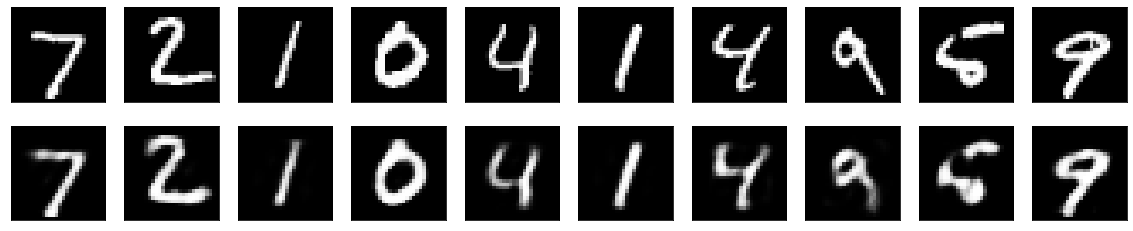

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
